In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../datasets/combined_odds_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Season'].astype(str)

temporadas_entrenamiento = ['2019-20', '2020-21', '2021-22', '2022-23']
df_train = df[df['Season'].isin(temporadas_entrenamiento)].copy()
df_test = df[df['Season'] == '2023-24'].copy()

equipos = sorted(pd.unique(df_train[['HomeTeam', 'AwayTeam']].values.ravel()))
n = len(equipos)
idx = {team: i for i, team in enumerate(equipos)}


In [4]:
def poisson_bivariante(x, y, lambda1, lambda2, lambda3):
    prob = 0.0
    for z in range(0, min(x, y)+1):
        prob += poisson.pmf(z, lambda3) * poisson.pmf(x-z, lambda1) * poisson.pmf(y-z, lambda2)
    return max(prob, 1e-10)

def logverosimilitud_ext(params):
    ataque = params[:n]
    defensa = params[n:2*n]
    gamma = params[2*n]
    phi_home = params[2*n+1:3*n+1]
    phi_away = params[3*n+1:]

    log_lik = 0
    for _, row in df_train.iterrows():
        i = idx[row['HomeTeam']]
        j = idx[row['AwayTeam']]
        g_home = row['FTHG']
        g_away = row['FTAG']

        lambda_home = np.exp(ataque[i] - defensa[j] + gamma)
        lambda_away = np.exp(ataque[j] - defensa[i])
        lambda3 = np.exp(phi_home[i] + phi_away[j])

        lambda1 = max(lambda_home - lambda3, 1e-5)
        lambda2 = max(lambda_away - lambda3, 1e-5)

        p = poisson_bivariante(g_home, g_away, lambda1, lambda2, lambda3)
        log_lik += np.log(p)

    return -log_lik

In [5]:
np.random.seed(42)
x0 = np.concatenate([
    np.random.normal(0, 0.1, n),  # ataque
    np.random.normal(0, 0.1, n),  # defensa
    [0.1],                        # gamma
    np.random.normal(0, 0.1, n),  # phi_home
    np.random.normal(0, 0.1, n)   # phi_away
])
bounds = [(-5, 5)] * (2*n) + [(-1, 1)] + [(-2, 2)] * (2*n)

res = minimize(logverosimilitud_ext, x0, method='L-BFGS-B', bounds=bounds)

ataque = dict(zip(equipos, res.x[:n]))
defensa = dict(zip(equipos, res.x[n:2*n]))
gamma = res.x[2*n]
phi_home = dict(zip(equipos, res.x[2*n+1:3*n+1]))
phi_away = dict(zip(equipos, res.x[3*n+1:]))


In [6]:
max_goals = 6
preds = []

for _, row in df_test.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    if home not in ataque or away not in ataque:
        continue

    lambda_home = np.exp(ataque[home] - defensa[away] + gamma)
    lambda_away = np.exp(ataque[away] - defensa[home])
    lambda3 = np.exp(phi_home[home] + phi_away[away])

    lambda1 = max(lambda_home - lambda3, 1e-5)
    lambda2 = max(lambda_away - lambda3, 1e-5)

    matriz = np.zeros((max_goals, max_goals))
    for i in range(max_goals):
        for j in range(max_goals):
            matriz[i, j] = poisson_bivariante(i, j, lambda1, lambda2, lambda3)

    p_home = np.tril(matriz, -1).sum()
    p_draw = np.trace(matriz)
    p_away = np.triu(matriz, 1).sum()

    pred_label = ['H', 'D', 'A'][np.argmax([p_home, p_draw, p_away])]

    preds.append({
        'HomeTeam': home,
        'AwayTeam': away,
        'FTR_real': row['FTR'],
        'Pred': pred_label
    })

df_preds = pd.DataFrame(preds)

Accuracy: 0.532
F1 Score (macro): 0.424

Classification Report:
               precision    recall  f1-score   support

           A       0.49      0.52      0.51        95
           D       0.33      0.05      0.09        97
           H       0.56      0.85      0.68       150

    accuracy                           0.53       342
   macro avg       0.46      0.47      0.42       342
weighted avg       0.48      0.53      0.46       342



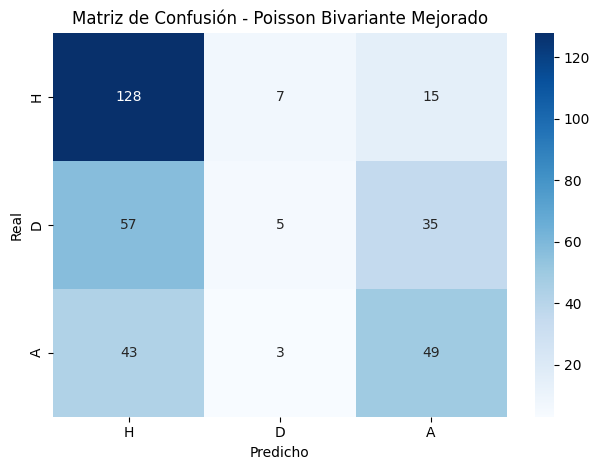

In [7]:
y_true = df_preds['FTR_real']
y_pred = df_preds['Pred']

print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 3))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=['H', 'D', 'A'])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['H', 'D', 'A'], yticklabels=['H', 'D', 'A'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Poisson Bivariante Mejorado")
plt.tight_layout()
plt.show()